In [25]:
%pip install torchsummary


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
# ================================
# 1. Imports and Constants
# ================================
import os
import torch
import librosa
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from torchsummary import summary

print("✅ All libraries imported successfully.")

# Constants
# SAMPLE_RATE = 48000
# N_MELS = 64
# N_FFT = 2048
# HOP_LENGTH = 512
# FIXED_LENGTH = 304
# BATCH_S= 0.001IZE = 8
# EPOCHS = 30
# LEARNING_RATE 
# Audio & feature extraction
SAMPLE_RATE = 48000
N_MELS = 64           # Enough to capture speech formants without too much computation
N_FFT = 1024          # Good frequency resolution for speech
HOP_LENGTH = 512      # ~10.67 ms step size, decent time resolution
FIXED_LENGTH = 304    # From your dataset analysis

# Training
BATCH_SIZE = 8        # Increase if GPU memory allows (try 16 or 32 if possible)
EPOCHS = 30
LEARNING_RATE = 0.001 # Adam optimizer default works well for CNNs
WEIGHT_DECAY = 1e-5   # Helps regularization

# Model / optimization
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PATIENCE = 5          # Early stopping patience (epochs without improvement)

DATASET_PATH = r"C:\Users\Shahanaj\OneDrive\Desktop\ASQUIRE PROJECT IISC\classiefier\segmentation_data_timestamp"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {DEVICE}")


✅ All libraries imported successfully.
✅ Using device: cpu


In [27]:
class PhonemeDataset(Dataset):
    def __init__(self, root_dir):
        self.samples = []
        self.labels = []
        for subdir, _, files in os.walk(root_dir):
            for file in files:
                if file.endswith(".wav"):
                    audio_path = os.path.join(subdir, file)
                    label_file = file.replace(".wav", ".txt")
                    label_path = os.path.join(subdir, label_file)
                    if os.path.exists(label_path):
                        with open(label_path, "r") as f:
                            label = f.readline().strip()
                            self.samples.append(audio_path)
                            self.labels.append(label)
        print(f"✅ Found {len(self.samples)} audio samples.")

        self.le = LabelEncoder()
        self.labels = self.le.fit_transform(self.labels)
        print("✅ Labels encoded.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path = self.samples[idx]
        label = self.labels[idx]
        audio, _ = librosa.load(path, sr=SAMPLE_RATE)
        mel = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_fft=N_FFT,
                                             hop_length=HOP_LENGTH, n_mels=N_MELS)
        mel_db = librosa.power_to_db(mel, ref=np.max)
        if mel_db.shape[1] < FIXED_LENGTH:
            pad = FIXED_LENGTH - mel_db.shape[1]
            mel_db = np.pad(mel_db, ((0, 0), (0, pad)), mode="constant")
        else:
            mel_db = mel_db[:, :FIXED_LENGTH]
        mel_db = (mel_db - mel_db.mean()) / mel_db.std()
        return torch.tensor(mel_db).unsqueeze(0).float(), label

# Load dataset
dataset = PhonemeDataset(DATASET_PATH)
if len(dataset) == 0:
    raise ValueError("❌ Dataset is empty.")
print("✅ Dataset loaded and processed.")


✅ Found 6810 audio samples.
✅ Labels encoded.
✅ Dataset loaded and processed.


In [28]:
num_classes = len(np.unique(dataset.labels))
print(f"✅ Number of phoneme classes: {num_classes}")

train_len = int(0.7 * len(dataset))
val_len = int(0.15 * len(dataset))
test_len = len(dataset) - train_len - val_len

train_set, val_set, test_set = random_split(dataset, [train_len, val_len, test_len])
print("✅ Dataset split into train, val, and test sets.")

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE)
print("✅ DataLoaders created.")


✅ Number of phoneme classes: 11
✅ Dataset split into train, val, and test sets.
✅ DataLoaders created.


In [29]:
class PhonemeCNN(nn.Module):
    def __init__(self, num_classes):
        super(PhonemeCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4))
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

model = PhonemeCNN(num_classes).to(DEVICE)
print("✅ CNN model instantiated.")

# Model summary
summary(model, input_size=(1, N_MELS, FIXED_LENGTH))


✅ CNN model instantiated.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 64, 304]             160
              ReLU-2          [-1, 16, 64, 304]               0
         MaxPool2d-3          [-1, 16, 32, 152]               0
            Conv2d-4          [-1, 32, 32, 152]           4,640
              ReLU-5          [-1, 32, 32, 152]               0
         MaxPool2d-6           [-1, 32, 16, 76]               0
            Conv2d-7           [-1, 64, 16, 76]          18,496
              ReLU-8           [-1, 64, 16, 76]               0
 AdaptiveAvgPool2d-9             [-1, 64, 4, 4]               0
          Flatten-10                 [-1, 1024]               0
           Linear-11                  [-1, 128]         131,200
             ReLU-12                  [-1, 128]               0
          Dropout-13                  [-1, 128]               0
           Li

In [30]:
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(dataset.labels),
                                     y=dataset.labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)
print("✅ Class weights computed for imbalance handling.")

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print("✅ Loss function and optimizer initialized.")


✅ Class weights computed for imbalance handling.
✅ Loss function and optimizer initialized.


In [31]:
from sklearn.metrics import accuracy_score, f1_score, precision_score

train_f1s, val_f1s, train_accs, val_accs = [], [], [], []

# Variables to store last epoch's predictions for final metrics
final_train_labels, final_train_preds = [], []
final_val_labels, final_val_preds = [], []

for epoch in range(EPOCHS):
    print(f"\n🚀 Epoch {epoch+1}/{EPOCHS}")
    
    # ======== TRAINING ========
    model.train()
    correct, total, epoch_preds, epoch_labels = 0, 0, [], []
    
    for mel, label in train_loader:
        mel, label = mel.to(DEVICE), label.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(mel)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
        epoch_preds += predicted.tolist()
        epoch_labels += label.tolist()

    train_acc = correct / total
    train_f1 = f1_score(epoch_labels, epoch_preds, average='macro')
    train_accs.append(train_acc)
    train_f1s.append(train_f1)
    
    # Store last epoch results
    if epoch == EPOCHS - 1:
        final_train_labels = epoch_labels
        final_train_preds = epoch_preds

    # ======== VALIDATION ========
    model.eval()
    correct, total, val_preds, val_labels = 0, 0, [], []
    with torch.no_grad():
        for mel, label in val_loader:
            mel, label = mel.to(DEVICE), label.to(DEVICE)
            outputs = model(mel)
            _, predicted = torch.max(outputs.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
            val_preds += predicted.tolist()
            val_labels += label.tolist()

    val_acc = correct / total
    val_f1 = f1_score(val_labels, val_preds, average='macro')
    val_accs.append(val_acc)
    val_f1s.append(val_f1)
    
    # Store last epoch results
    if epoch == EPOCHS - 1:
        final_val_labels = val_labels
        final_val_preds = val_preds

    print(f"✅ Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}")
    print(f"✅ Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

    if val_f1 == max(val_f1s):
        torch.save(model.state_dict(), "best_model.pth")
        print("💾 Best model saved.")

print("🎉 Training complete.")

# ======== TEST EVALUATION ========
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
final_test_labels, final_test_preds = [], []
with torch.no_grad():
    for mel, label in test_loader:
        mel, label = mel.to(DEVICE), label.to(DEVICE)
        outputs = model(mel)
        _, predicted = torch.max(outputs.data, 1)
        final_test_labels += label.tolist()
        final_test_preds += predicted.tolist()

# ======== FINAL METRICS ========
print("\n========== FINAL RESULTS ==========")
print(f"Final Train Accuracy: {accuracy_score(final_train_labels, final_train_preds) * 100:.2f}%")
print(f"Final Val Accuracy: {accuracy_score(final_val_labels, final_val_preds) * 100:.2f}%")
print(f"Final Test Accuracy: {accuracy_score(final_test_labels, final_test_preds) * 100:.2f}%")

print(f"Final Macro F1: {f1_score(final_test_labels, final_test_preds, average='macro'):.4f}")
print(f"Final Micro F1: {f1_score(final_test_labels, final_test_preds, average='micro'):.4f}")

print(f"Final Macro Precision: {precision_score(final_test_labels, final_test_preds, average='macro'):.4f}")
print(f"Final Micro Precision: {precision_score(final_test_labels, final_test_preds, average='micro'):.4f}")




🚀 Epoch 1/30
✅ Train Acc: 0.5425, Train F1: 0.4851
✅ Val Acc: 0.6259, Val F1: 0.5991
💾 Best model saved.

🚀 Epoch 2/30
✅ Train Acc: 0.6241, Train F1: 0.5811
✅ Val Acc: 0.6405, Val F1: 0.5787

🚀 Epoch 3/30
✅ Train Acc: 0.6654, Train F1: 0.6233
✅ Val Acc: 0.7228, Val F1: 0.6930
💾 Best model saved.

🚀 Epoch 4/30
✅ Train Acc: 0.7137, Train F1: 0.6687
✅ Val Acc: 0.7483, Val F1: 0.7047
💾 Best model saved.

🚀 Epoch 5/30
✅ Train Acc: 0.7481, Train F1: 0.7039
✅ Val Acc: 0.7855, Val F1: 0.7605
💾 Best model saved.

🚀 Epoch 6/30
✅ Train Acc: 0.7766, Train F1: 0.7353
✅ Val Acc: 0.7992, Val F1: 0.7541

🚀 Epoch 7/30
✅ Train Acc: 0.7942, Train F1: 0.7511
✅ Val Acc: 0.8129, Val F1: 0.7780
💾 Best model saved.

🚀 Epoch 8/30
✅ Train Acc: 0.8064, Train F1: 0.7709
✅ Val Acc: 0.8012, Val F1: 0.7631

🚀 Epoch 9/30
✅ Train Acc: 0.8135, Train F1: 0.7778
✅ Val Acc: 0.8374, Val F1: 0.8046
💾 Best model saved.

🚀 Epoch 10/30
✅ Train Acc: 0.8169, Train F1: 0.7849
✅ Val Acc: 0.8423, Val F1: 0.8062
💾 Best model saved.

C:\Users\Shahanaj\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


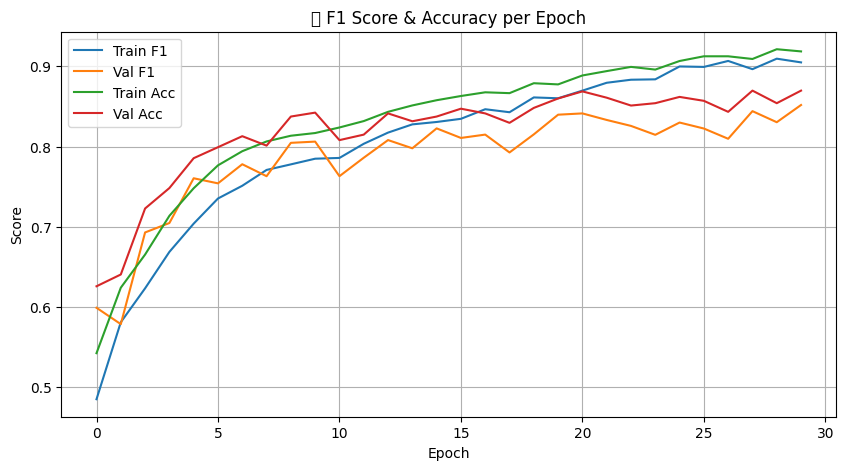

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(train_f1s, label="Train F1")
plt.plot(val_f1s, label="Val F1")
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.title("📊 F1 Score & Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()


✅ Best model loaded for final evaluation.

📦 Training ground truth samples: 4767
📊 Training class distribution: Counter({1: 1006, 8: 592, 3: 562, 2: 435, 0: 413, 5: 391, 6: 349, 7: 339, 10: 328, 9: 311, 4: 41})
📈 Training Accuracy: 95.64%
📉 Training F1-score: 0.9562

📦 Validation ground truth samples: 1021
📊 Validation class distribution: Counter({1: 224, 8: 119, 3: 111, 2: 89, 7: 88, 0: 83, 10: 81, 5: 79, 9: 75, 6: 60, 4: 12})
📈 Validation Accuracy: 86.97%
📉 Validation F1-score: 0.8698

📦 Testing ground truth samples: 1022
📊 Testing class distribution: Counter({1: 213, 8: 137, 3: 119, 5: 84, 0: 81, 7: 81, 6: 81, 2: 80, 10: 72, 9: 67, 4: 7})
📈 Testing Accuracy: 88.55%
📉 Testing F1-score: 0.8855

📋 Test Classification Report:
              precision    recall  f1-score   support

          aa       0.92      0.95      0.93        81
          cc       1.00      1.00      1.00       213
          ee       0.78      0.84      0.81        80
          ii       0.90      0.82      0.86     

C:\Users\Shahanaj\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


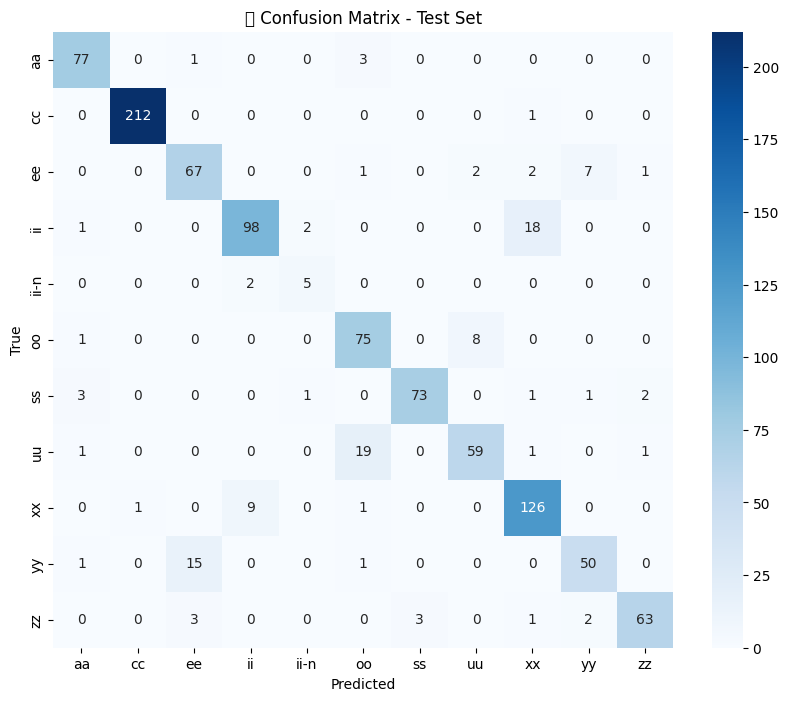

In [48]:
from collections import Counter
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# -----------------------------
# Function to collect predictions & ground truth
# -----------------------------
def get_predictions(model, dataloader):
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

# -----------------------------
# Load best model
# -----------------------------
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
print("✅ Best model loaded for final evaluation.")

# -----------------------------
# TRAIN RESULTS
# -----------------------------
y_train_true, y_train_pred = get_predictions(model, train_loader)
print(f"\n📦 Training ground truth samples: {len(y_train_true)}")
print(f"📊 Training class distribution: {Counter(y_train_true)}")
print(f"📈 Training Accuracy: {accuracy_score(y_train_true, y_train_pred) * 100:.2f}%")
print(f"📉 Training F1-score: {f1_score(y_train_true, y_train_pred, average='weighted'):.4f}")

# -----------------------------
# VALIDATION RESULTS (if available)
# -----------------------------
try:
    y_val_true, y_val_pred = get_predictions(model, val_loader)
    print(f"\n📦 Validation ground truth samples: {len(y_val_true)}")
    print(f"📊 Validation class distribution: {Counter(y_val_true)}")
    print(f"📈 Validation Accuracy: {accuracy_score(y_val_true, y_val_pred) * 100:.2f}%")
    print(f"📉 Validation F1-score: {f1_score(y_val_true, y_val_pred, average='weighted'):.4f}")
except NameError:
    print("\n⚠️ No validation loader found. Skipping validation results.")

# -----------------------------
# TEST RESULTS
# -----------------------------
y_test_true, y_test_pred = get_predictions(model, test_loader)
print(f"\n📦 Testing ground truth samples: {len(y_test_true)}")
print(f"📊 Testing class distribution: {Counter(y_test_true)}")
print(f"📈 Testing Accuracy: {accuracy_score(y_test_true, y_test_pred) * 100:.2f}%")
print(f"📉 Testing F1-score: {f1_score(y_test_true, y_test_pred, average='weighted'):.4f}")

print("\n📋 Test Classification Report:")
print(classification_report(y_test_true, y_test_pred, target_names=dataset.le.classes_))

# -----------------------------
# Confusion Matrix for Test Set
# -----------------------------
cm = confusion_matrix(y_test_true, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=dataset.le.classes_,
            yticklabels=dataset.le.classes_, cmap='Blues')
plt.title("🧩 Confusion Matrix - Test Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()




In [51]:
import torch
from sklearn.metrics import accuracy_score

# Set device globally
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# After training, collect predictions and true labels for each split
def get_predictions(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)  # now device is defined
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

# Get true & predicted labels
y_train_true, y_train_pred = get_predictions(model, train_loader)
y_val_true, y_val_pred = get_predictions(model, val_loader)
y_test_true, y_test_pred = get_predictions(model, test_loader)

# Now you can print results
print("\n========== FINAL RESULTS ==========")
print(f"Final Train Accuracy: {accuracy_score(y_train_true, y_train_pred) * 100:.2f}%")
print(f"Final Val Accuracy: {accuracy_score(y_val_true, y_val_pred) * 100:.2f}%")
print(f"Final Test Accuracy: {accuracy_score(y_test_true, y_test_pred) * 100:.2f}%")




========== FINAL RESULTS ==========
Final Train Accuracy: 95.64%
Final Val Accuracy: 86.97%
Final Test Accuracy: 88.55%


In [53]:
import torch

def pad_or_truncate(mel, target_frames=304):
    if mel.shape[1] < target_frames:
        pad_width = target_frames - mel.shape[1]
        mel = torch.nn.functional.pad(mel, (0, pad_width))
    else:
        mel = mel[:, :target_frames]
    return mel